In [1]:
import pandas as pd
import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from xgboost import XGBClassifier

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import gc

d:\Programming\Languages\Python Venvs\data\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAVES_FOLDER = "OptunaDataSaves"
if not os.path.isdir(SAVES_FOLDER):
    os.mkdir(SAVES_FOLDER)

In [3]:
train_df = pd.read_csv("data/train.csv", index_col="id")
test_df = pd.read_csv("data/test.csv", index_col="id")

In [4]:
def convert_cols(df, day_as_cat=False):
    try:
        df["rainfall"] = df["rainfall"].astype(pd.UInt8Dtype())
    except KeyError:
        print("WARN: No 'rainfall' column found")
    # float_cols = ["pressure", "maxtemp", "temperature", "mintemp", "dewpoint", "humidity", "cloud", "sunshine", "winddirection", "windspeed"]

    if day_as_cat:
        df["day"] = df["day"].astype("categorical")

    df = df.rename(columns={"temparature":"temperature"})

    return df

TARGET_FEAT = "rainfall"

train_df = convert_cols(train_df)
test_df = convert_cols(test_df)

WARN: No 'rainfall' column found


In [5]:
def undersample(df, target_col, class_to_match):
    unique_classes = df[target_col].unique()
    
    class_dfs = {i:df[df[target_col] == i] for i in unique_classes}
    
    min_sample_count = min([len(df) for df in class_dfs.values()])
    undersample_dfs = {}

    for k, v in class_dfs.items():
        if k != class_to_match:
            undersample_dfs[k] = v.sample(min_sample_count)

    downsampled_df = class_dfs[class_to_match]
    for v in undersample_dfs.values():
        downsampled_df = pd.concat([downsampled_df, v])

    class_dfs = None
    undersample_dfs = None
    gc.collect()

    return downsampled_df

downsampled_df = undersample(train_df, TARGET_FEAT, 0)

In [24]:
def plot_roc_auc_curve(pred_df, y_true, save_path):

    fig, ax = plt.subplots(1, 2, figsize=(20,10))

    cm = confusion_matrix(y_true, pred_df["preds"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[0], values_format=",")

    disp = RocCurveDisplay.from_predictions(
        y_true,
        pred_df["preds"],
        name="ROC of Response",
        plot_chance_level=True,
        ax=ax[1]
    )
    disp.figure_.savefig(save_path)

In [28]:
def run_epoch(model, X, y, kf, metrics=[accuracy_score], proba=False):
    scores = [[] for metric in metrics]

    for train_index, test_index in kf.split(X, y):
        model_clone = sklearn.base.clone(model)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_clone.fit(X_train, y_train)
        if proba:
            y_pred = model_clone.predict_proba(X_test)
        else:
            y_pred = model_clone.predict(X_test)

        for i, metric in enumerate(metrics):
            if proba:
                score = metric(y_test, y_pred[:, 1])
            else:
                score = metric(y_test, y_pred)
            scores[i].append(score)

    return scores


class ObjectiveCV(object):
    def __init__(
        self, train_set, kfold, use_model, n_jobs, random_state=0, proba=False
    ):
        self.train = train_set
        self.use_model = use_model

        self.kfold = kfold

        self.n_jobs = n_jobs
        self.random_state = random_state
        self.proba = proba

        self.__models = {
            "rf": self.__model_rf,
            "xgb": self.__model_xgb,
            "logreg": self.__model_logreg,
        }

    def __model_rf(self, trial):
        # bootstrap = trial.suggest_categorical("bootstrap", [True, False])
        # max_sample = None
        # if bootstrap:
        #     max_sample = trial.suggest_float("max_samples", 0, 1)

        return RandomForestClassifier(
            random_state=self.random_state,
            n_jobs=self.n_jobs,
            n_estimators=trial.suggest_int("n_estimators", 500, 1500),
            max_depth=trial.suggest_int("max_depth", 4, 7),
            min_samples_split=trial.suggest_float("min_samples_split", 0, 0.1),
            min_samples_leaf=trial.suggest_float("min_samples_leaf", 0, 0.05),
            min_weight_fraction_leaf=trial.suggest_float(
                "min_weight_fraction_leaf", 0, 0.05
            ),
            max_features=trial.suggest_float("max_features", 0.5, 1),
            class_weight=trial.suggest_categorical(
                "class_weight", ["balanced", "balanced_subsample"]
            ),
            # max_leaf_nodes=trial.suggest_int("mlf", 0, 5e3),
            # min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0, 5e3),
            # bootstrap=bootstrap,
            # warm_start=trial.suggest_categorical("warm_start", [True, False]),
            # max_samples=max_sample,
            # ccp_alpha=trial.suggest_float("ccp_alpha", 0, 5e3),
        )

    def __model_xgb(self, trial):
        return XGBClassifier(
            enable_categorical=True,
            random_state=self.random_state,
            n_jobs=self.n_jobs,
            n_estimators=trial.suggest_int("n_estimators", 1, 1000),
            eta=trial.suggest_float("eta", 0.01, 1),
            gamma=trial.suggest_float("gamma", 0, 20),
            max_depth=trial.suggest_int("max_depth", 3, 10, step=1),
            max_leaves=trial.suggest_int("max_leaves", 0, 1000),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.05, 1),
            colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1),
            colsample_bynode=trial.suggest_float("colsample_bynode", 0.05, 1),
            reg_lambda=trial.suggest_int("reg_lambda", 0, 20),
            reg_alpha=trial.suggest_int("reg_alpha", 0, 20),
            grow_policy=trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            ),
            min_child_weight=trial.suggest_float("min_child_weight", 0, 200),
            max_delta_step=trial.suggest_float("max_delta_step", 0, 100),
        )

    def __model_logreg(self, trial):
        penalty = trial.suggest_categorical("penalty", [None, "l1", "l2", "elasticnet"])
        logreg_c = trial.suggest_int("logreg_c", 1, 100)

        if penalty == "elasticnet":
            l1_ratio = trial.suggest_float("l1_ratio", 0, 1)
            clf = LogisticRegression(
                random_state=self.random_state,
                n_jobs=self.n_jobs,
                penalty=penalty,
                C=logreg_c,
                l1_ratio=l1_ratio,
                solver="saga",
                max_iter=int(1e5),
            )

        else:
            clf = LogisticRegression(
                random_state=self.random_state,
                n_jobs=self.n_jobs,
                penalty=penalty,
                C=logreg_c,
                solver="saga",
                max_iter=int(1e5),
            )

        return clf

    def __call__(self, trial):
        model = self.__models[self.use_model](trial)

        x = self.train.drop(columns=[TARGET_FEAT])
        y = self.train[TARGET_FEAT]

        scores = run_epoch(
            model, x, y, self.kfold, metrics=[roc_auc_score], proba=self.proba
        )
        return np.mean(scores[0])

### RF

In [10]:
STUDY_NAME = "rf_all_proba"

if not os.path.isdir(os.path.join(SAVES_FOLDER, STUDY_NAME)):
    os.mkdir(os.path.join(SAVES_FOLDER, STUDY_NAME))

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///optuna.sqlite3",
    study_name=STUDY_NAME,
    load_if_exists=True
)
objective = ObjectiveCV(train_df, skf, "rf", n_jobs=-1, proba=True)

study.optimize(objective, n_trials=200)
gc.collect()

[I 2025-03-12 11:55:31,797] Using an existing study with name 'rf_all_proba' instead of creating a new one.
[I 2025-03-12 11:55:46,518] Trial 1 finished with value: 0.8861503928170595 and parameters: {'n_estimators': 986, 'max_depth': 4, 'min_samples_split': 0.08747927050993867, 'min_samples_leaf': 0.04447312431113976, 'min_weight_fraction_leaf': 0.010581005155679469, 'max_features': 0.8611032210823244, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.8861503928170595.
[I 2025-03-12 11:55:55,655] Trial 2 finished with value: 0.889472502805836 and parameters: {'n_estimators': 854, 'max_depth': 4, 'min_samples_split': 0.022899926443858687, 'min_samples_leaf': 0.0017110128936964843, 'min_weight_fraction_leaf': 0.031060984806818032, 'max_features': 0.9321008282191929, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.889472502805836.
[I 2025-03-12 11:56:12,146] Trial 3 finished with value: 0.8861728395061729 and parameters: {'n_estimators': 1088, 'max_depth': 5

253

In [12]:
study.best_params

{'n_estimators': 1279,
 'max_depth': 7,
 'min_samples_split': 0.026894272767188022,
 'min_samples_leaf': 0.012568785880079793,
 'min_weight_fraction_leaf': 0.03341275135897351,
 'max_features': 0.8921458164806865,
 'class_weight': 'balanced'}

In [13]:
best_rf = RandomForestClassifier(
    random_state=0,
    n_jobs=-1,
    **study.best_params
)

x, y = train_df.drop(columns=[TARGET_FEAT]), train_df[TARGET_FEAT]
best_rf.fit(x, y)
rf_preds = best_rf.predict(x)

In [14]:
rf_preds = pd.DataFrame({"preds":rf_preds})
rf_preds.groupby("preds").value_counts()

preds
0.0     641
1.0    1549
Name: count, dtype: int64

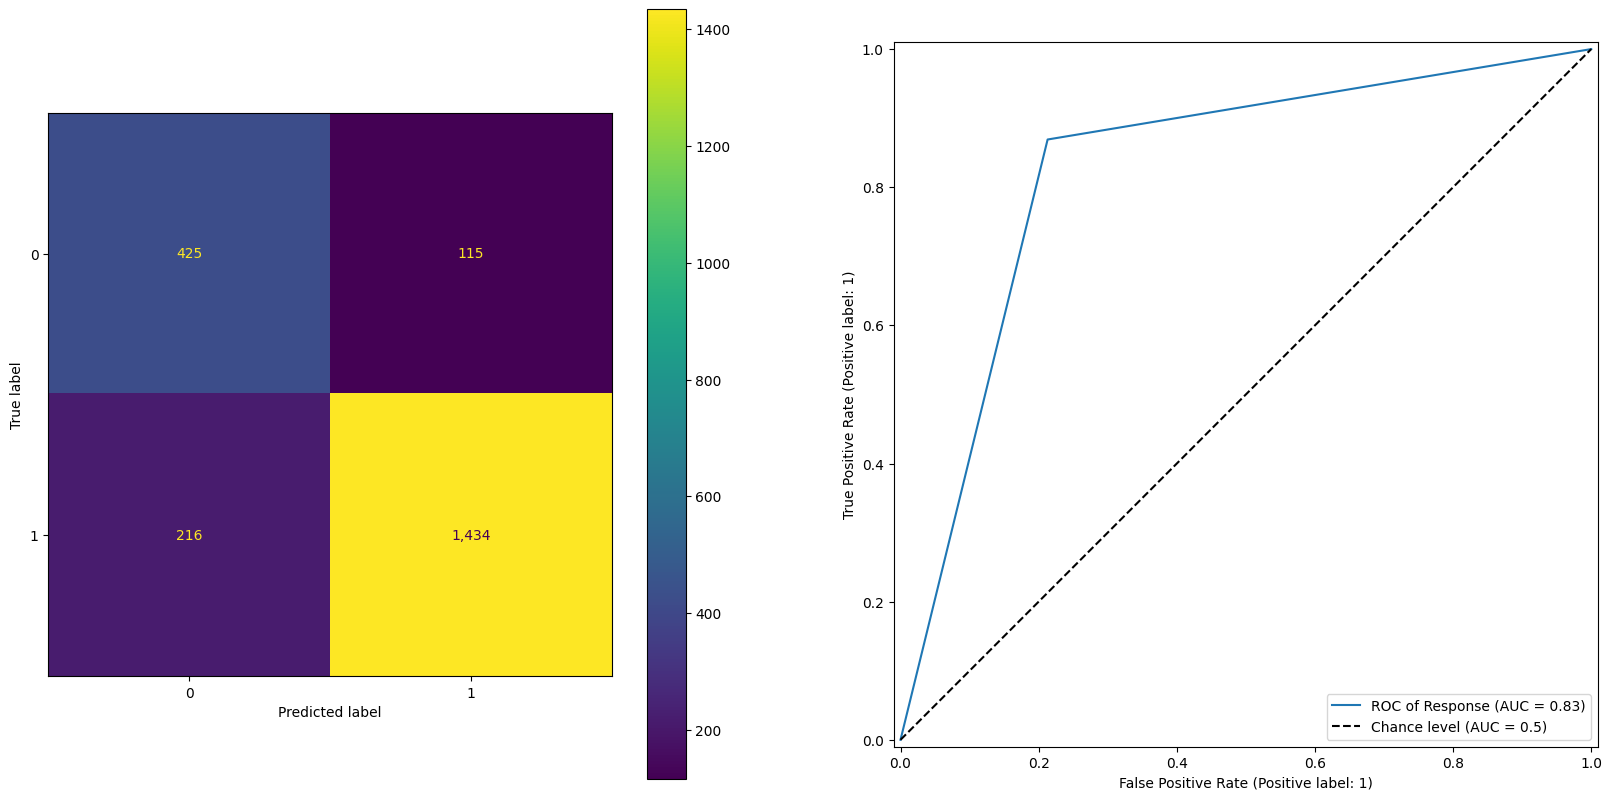

In [26]:
plot_roc_auc_curve(rf_preds, y, os.path.join(SAVES_FOLDER, STUDY_NAME, f"{STUDY_NAME}.pdf"))

In [16]:
rf_test_probas = best_rf.predict_proba(test_df)
rf_test_probas = pd.DataFrame(data=rf_test_probas, index=test_df.index)
rf_test_probas = rf_test_probas.rename(columns={1:TARGET_FEAT})
rf_test_probas[TARGET_FEAT].to_csv(os.path.join(SAVES_FOLDER, STUDY_NAME, f"{STUDY_NAME}.csv"))

### XGB

In [ ]:
STUDY_NAME = "xgb_all_proba"
if not os.path.isdir(os.path.join(SAVES_FOLDER, STUDY_NAME)):
    os.mkdir(os.path.join(SAVES_FOLDER, STUDY_NAME))

study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///optuna.sqlite3",
    study_name=STUDY_NAME,
    load_if_exists=True
)
objective = ObjectiveCV(train_df, skf, "xgb", n_jobs=-1, proba=True)

study.optimize(objective, n_trials=100)
gc.collect()

[I 2025-03-12 13:00:16,982] A new study created in RDB with name: xgb_all_proba
[I 2025-03-12 13:00:17,286] Trial 0 finished with value: 0.8767003367003368 and parameters: {'n_estimators': 55, 'eta': 0.47613599155455494, 'gamma': 1.500098515627033, 'max_depth': 10, 'max_leaves': 264, 'colsample_bytree': 0.9099601773463601, 'colsample_bylevel': 0.6243725708213446, 'colsample_bynode': 0.7378177015952073, 'reg_lambda': 19, 'reg_alpha': 14, 'grow_policy': 'depthwise', 'min_child_weight': 125.58370087048705, 'max_delta_step': 12.23948838161888}. Best is trial 0 with value: 0.8767003367003368.
[I 2025-03-12 13:00:17,731] Trial 1 finished with value: 0.8565824915824916 and parameters: {'n_estimators': 205, 'eta': 0.2594577801613348, 'gamma': 1.6477355025347484, 'max_depth': 9, 'max_leaves': 365, 'colsample_bytree': 0.6104204281653358, 'colsample_bylevel': 0.39983230083546506, 'colsample_bynode': 0.233570351427058, 'reg_lambda': 17, 'reg_alpha': 11, 'grow_policy': 'lossguide', 'min_child_weigh

7681

In [32]:
study.best_params

{'n_estimators': 383,
 'eta': 0.32210234165932483,
 'gamma': 0.0896118659378673,
 'max_depth': 9,
 'max_leaves': 446,
 'colsample_bytree': 0.5717597934548041,
 'colsample_bylevel': 0.05549328062032871,
 'colsample_bynode': 0.5439578622769937,
 'reg_lambda': 9,
 'reg_alpha': 6,
 'grow_policy': 'depthwise',
 'min_child_weight': 22.155528579522283,
 'max_delta_step': 64.8404498845379}

In [34]:
best_xgb = XGBClassifier(
    enable_categorical=True,
    random_state=0,
    n_jobs=-1,
    **study.best_params,
)

x, y = train_df.drop(columns=[TARGET_FEAT]), train_df[TARGET_FEAT]
best_xgb.fit(x, y)
xgb_preds = best_xgb.predict(x)

In [35]:
xgb_preds = pd.DataFrame({"preds":xgb_preds})
xgb_preds.groupby("preds").value_counts()

preds
0     476
1    1714
Name: count, dtype: int64

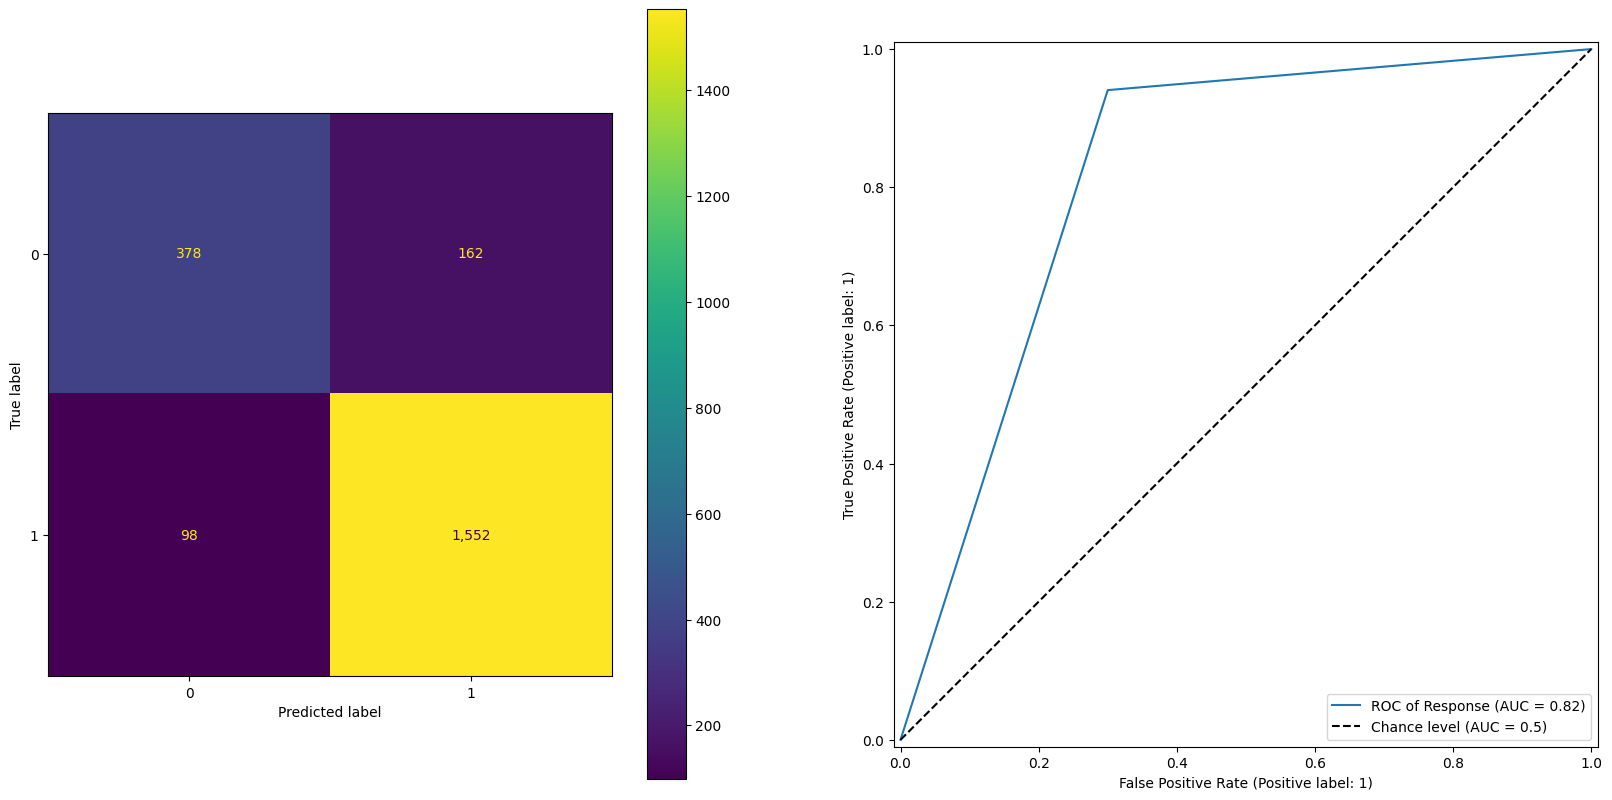

In [38]:
plot_roc_auc_curve(xgb_preds, y, os.path.join(SAVES_FOLDER, STUDY_NAME, f"{STUDY_NAME}.pdf"))

In [43]:
xgb_test_probas = best_xgb.predict_proba(test_df)
xgb_test_probas = pd.DataFrame(data=xgb_test_probas, index=test_df.index)
xgb_test_probas = xgb_test_probas.rename(columns={1:TARGET_FEAT})
xgb_test_probas[TARGET_FEAT].to_csv(os.path.join(SAVES_FOLDER, STUDY_NAME, f"{STUDY_NAME}.csv"))